In [1]:
## Load The Data
import json 
import pandas as pd
import math


raw = json.load(open('../data/without_space.json'))

for example in raw:
    for annotation in example['annotations']:
        #We expect the key of label to be label but the data has tag
        annotation['label'] = annotation['tag']
        
annotated_examples = [example for example in raw if example["annotations"] != []]
annotated_examples_ids = [example["example_id"] for example in annotated_examples]
print(len(annotated_examples))

3941


In [2]:
import numpy as np

#key:example_id
k_dict={}

def cal_entities(subset):
    entity_count = 0
    subinconsistent = 0
    tag_set = []
    j=0
    for item in subset:
        start = item.get('start')
        value = item.get('value')
        key = str(start)+value
        if key in tag_set:
            j = j+1
            continue
        else:         
            tag_set.append(key)
        for n in subset[j+1:]:
            if n.get("value") == item.get("value") and n.get("start")==item.get("start"):
                    subinconsistent = subinconsistent + 1
        if j+1==len(subset):
                break
        j=j+1
    entity_count = len(subset) - subinconsistent
    return entity_count

for example_idx, example in enumerate(annotated_examples):
    tag_set = {'Neutral':0,'Positive':1,'Negative':2}
    example_id = example["example_id"]
    annotator_num = len(example["seen_by"])
    annotations = example["annotations"]
    entity_num = cal_entities(annotations)
    if annotator_num == 1:
        k = 1.0
        k_dict[example_id] = k
        continue
    # key: start+value value: index
    tag_id = {}
    metrix = np.zeros((entity_num, 3), dtype=np.int_)
    for item in annotations:
        start = item.get('start')
        value = item.get('value')
        end = item.get('end')
        tag = item.get('tag')
        vote_num = len(item.get("annotated_by"))
        col_num = tag_set[tag]
        key = str(start)+value
        if key in tag_id:
            index = tag_id[key]
            metrix[index][col_num] = metrix[index][col_num] + vote_num        
        else:
            new_in = len(tag_id)
            tag_id[key] = new_in
            metrix[new_in][col_num] = vote_num  
    # kappa
    df = pd.DataFrame(metrix)
    #df = org_df[org_df.loc[:]!=0.0].dropna()
    total_task = annotator_num * entity_num
    N = annotator_num *(annotator_num-1)
    df.loc['pj'] = df.apply(lambda x: x.sum()/total_task)
    pe = df.loc['pj',0]**2 + df.loc['pj',1]**2 + df.loc['pj',2]**2
    df['pi'] = df.apply(lambda x: (x**2/N).sum(), axis=1) 
    df['pi'] = df['pi'] - 1/(annotator_num-1)
    ini_po = 0
    for i in range(entity_num):
        ini_po = df.loc[i,'pi'] + ini_po
    po = ini_po/entity_num  
    if(pe == 1):
        k = 1.0
        k_dict[example_id] = k
        continue
    k = (po-pe)/(1-pe)
    k_dict[example_id] = k

senti_con_0 = []
senti_con_20 = []
senti_con_40 = []
senti_con_60 = []
senti_con_80 = []
senti_con_100 = []
senti_con_100_max = []
for e_id in k_dict:
    k = k_dict[e_id]
    if k<=0:
        senti_con_0.append(e_id)
    if k>=0.01 and k<=0.2:
        senti_con_20.append(e_id)
    if k>=0.21 and k<=0.4:
        senti_con_40.append(e_id)
    if k>=0.41 and k<=0.6:
        senti_con_60.append(e_id)
    if k>=0.61 and k<=0.8:
        senti_con_80.append(e_id)
    if k>=0.81:
        senti_con_100.append(e_id)
        
for e_id in k_dict:
    k = k_dict[e_id]
    if k==1.0:
        senti_con_100_max.append(e_id)

In [3]:
print(len(senti_con_0))
print(len(senti_con_20))
print(len(senti_con_40))
print(len(senti_con_60))
print(len(senti_con_80))
print(len(senti_con_100))
print(len(senti_con_100_max))

2454
191
188
80
14
997
996


In [ ]:
# senti_sim = [ex for ex in raw if ex["example_id"] in (senti_con_100)]

# f = open("./data/FinEntity.json", 'w', encoding='utf-8')
# json.dump(senti_sim, f)
# f.close()

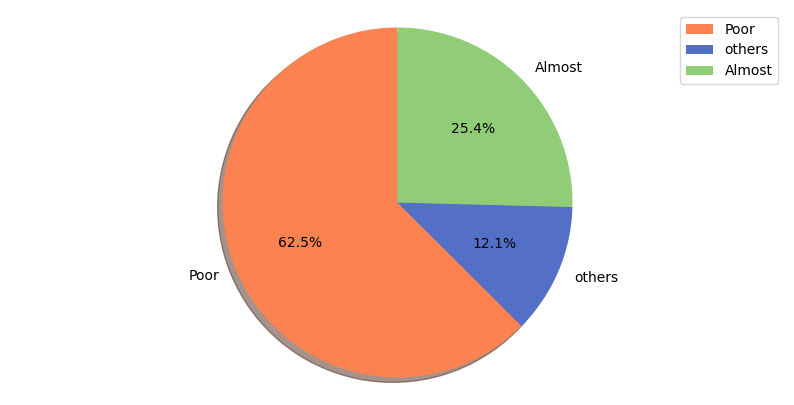

In [4]:
## plot 
import matplotlib.pyplot as plt
labels = ["Poor","others","Almost"]
other = len(senti_con_20)+len(senti_con_40)+len(senti_con_60)+len(senti_con_80)
sizes = [len(senti_con_0),other,len(senti_con_100)]
colors = ['#fc8251','#5470c6','#91cd77','#ef6567','#f9c956','#75bedc']
params = {
    'figure.figsize': '10, 5'
}
plt.rcParams.update(params)
explode = None
fig1, ax1 = plt.subplots()
ax1.pie(x = sizes,labels=labels ,autopct='%1.1f%%', colors =colors,radius=1,shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend()
plt.show()

6307
annotators: ['htwongax', 'jiwooshim', 'chuak', 'ycyeungae', 'cychandw', 'lhchengaf', 'yzhucw', 'rzhangbu', 'tcrlau', 'kzhouaf', 'akamath', 'kkchanbk']
tags: ['Neutral', 'Positive', 'Negative']


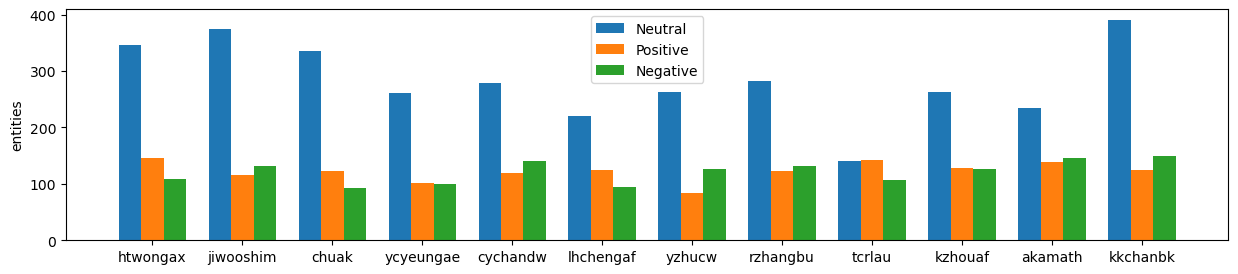

In [12]:
## Number and percentage of entities of each annotator
import sys
sys.path.append("..")
from util.process import cal_annotator,plot_feature
import numpy as np
import matplotlib.pyplot as plt
raw = [ex for ex in raw if ex["example_id"] in (senti_con_100)]
name_set,label_set,annotator = cal_annotator(raw)
## check correct
print(sum(sum(i) for i in annotator))
print("annotators:",list(name_set.keys()))
print("tags:",list(label_set.keys()))

names = list(name_set.keys())
Neutral = annotator[:,0]
Positive = annotator[:,1]
Negative = annotator[:,2]

params = {
    'figure.figsize': '15, 3'
}
plt.rcParams.update(params)

plt.subplot()
x = np.arange(len(names))
width = 0.25
plt.bar(x - width, Neutral, width, label='Neutral')
plt.bar(x, Positive, width, label='Positive')
plt.bar(x + width, Negative, width, label='Negative')
plt.ylabel('entities')
plt.xticks(x, labels=names)
plt.legend()
plt.show()

all entities : 6307
Negative  tag count:  1452
Positive  tag count:  1467
Neutral  tag count:  3388


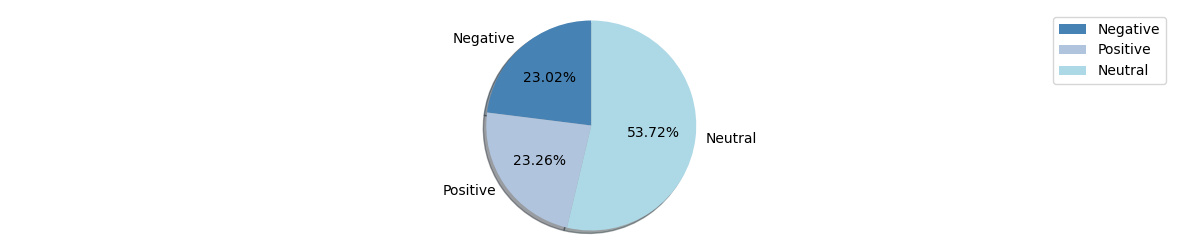

In [13]:
plot_feature(raw)